In [14]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings

## Загрузим данные в датафрейм и посмотрим, что он из себя предстваляет

In [15]:
df_data = pd.read_csv('uplift_synthetic_data_100trials.csv')
df_model = df_data.copy()

In [16]:
df_model.head(5)

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


In [17]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1000000 non-null  int64  
 1   trial_id                    1000000 non-null  int64  
 2   treatment_group_key         1000000 non-null  object 
 3   conversion                  1000000 non-null  int64  
 4   control_conversion_prob     1000000 non-null  float64
 5   treatment1_conversion_prob  1000000 non-null  float64
 6   treatment1_true_effect      1000000 non-null  float64
 7   x1_informative              1000000 non-null  float64
 8   x2_informative              1000000 non-null  float64
 9   x3_informative              1000000 non-null  float64
 10  x4_informative              1000000 non-null  float64
 11  x5_informative              1000000 non-null  float64
 12  x6_informative              1000000 non-null  float64
 13

In [18]:
df_model.describe(include=np.object)

,treatment_group_key
count,1000000
unique,2
top,control
freq,500000


In [19]:
# Переименуем целевой признак (таргет) и столбец treatment_group_key -> treatment
df_model = df_model.rename(columns={'conversion': 'target'})

df_model = df_model.rename(columns={'treatment_group_key': 'treatment'})
df_model.treatment = df_model.treatment.map({'control': 0, 'treatment1': 1})

In [21]:
df_model = pd.get_dummies(df_model)

## Определим классы испытаний

* <h3> Control Non-Responders(CN) </h3>
Испытания из контрольной группы (без воздействия), которые прошли неуспешно (value = 0)

* <h3> Control Responders(CR) </h3>
Испытания из контрольной группы (без воздействия), которые прошли успешно (value = 1)

* <h3> Treatment Non-Responders(TN) </h3>
Испытания из целевой группы (с воздействием), которые прошли неуспешно (value = 2)

* <h3> Treatment Responders(TR) </h3>
Испытания из целевой группы (с воздействием), которые прошли успешно (value = 3)


In [22]:
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3
    return df

df_model = declare_tc(df_model)

## Зададим функции для обучения модели, обучим ее на данных и проверим на тесте
Тестовая/обучающая выборка - 30/70
Убираем все столбцы, кроме таргета и фич. Из фич оставим даже те, что считаются нерелевантными

In [26]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class', 'trial_id', 'control_conversion_prob', 'treatment1_conversion_prob', 'treatment1_true_effect', 'Unnamed: 0'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=3,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)


    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0]
    result['proba_CR'] = uplift_proba[:,1]
    result['proba_TN'] = uplift_proba[:,2]
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')
    # Put the result
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [27]:
# Run the uplift function
treatment_uplift = uplift(df_model)


/Users/mikhail/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Нурисуем QINI: зависимиость uplift эффекта от доли выборки, на которую будет оказываться вохдействие

In [28]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']


    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)


    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])


    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve ')

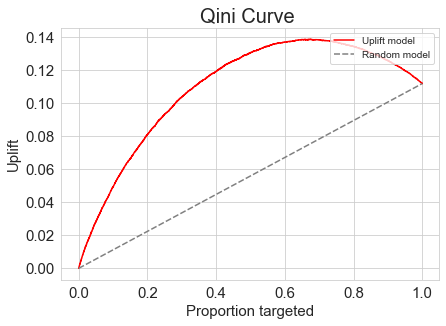

In [29]:
# plot the Qini curve for the treatment
qini(treatment_uplift)
plt.title('Qini Curve ',fontsize=20)

Видно, что модель работает лучше, чем случайная модель на тестовой выборке. При этом uplift эффект сильно растёт до примерно 0,7 пропорции воздействия, а дальше падает. Возможно, часть выборки показывает отрицательную реакцию на воздействие. Нужно уметь её вычленить по фичам